In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Making the dataset
To look at the weakness of k-means and think about how to improve the cluster model, some random blob data is created and plotted, and then KMeans is perfomed.

In [5]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=.6, random_state=0)
X = X[:, ::-1]

# Looking at the initial model

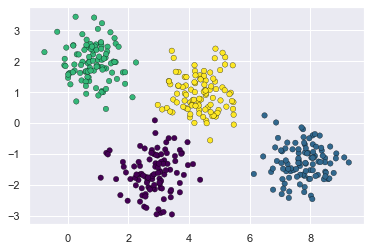

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap="viridis", edgecolors="black", linewidths=.3)



From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:


In [7]:
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap="viridis", zorder=2, edgecolor="black", linewidth=.5)

    # plot the representation of KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() 
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc="#AAA", lw=3, alpha=.5, zorder=1, edgecolor="black", linewidth=.1))

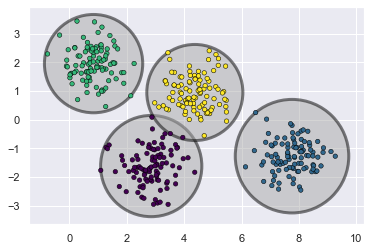

In [8]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

# Observation about circularity in KMeans
First observation is, that the circles are encompassing more labels, this might not be good. Second is, that KMeans only works on the assumption that the distribution of data is circular around a center. This becomes apparent if we transform the data, to become more oblique

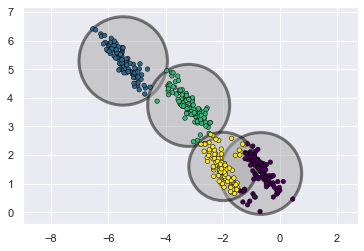

In [9]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2,2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

Not only do we get intersecting cirlces, where the question of whether points belong to yellow or purple are unanswerable, but we also get spheres not conforming to the oblique shape of the clusters.
These two disadvantages of k-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the k-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

# Gaussian Mixture Model
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

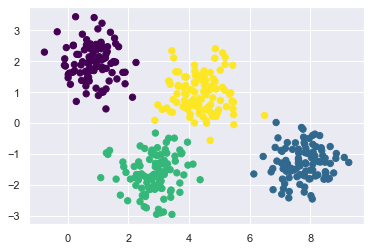

In [14]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the `predict_proba` method. This returns a matrix of size ```[n_samples, n_clusters]``` which measures the probability that any point belongs to the given cluster:

In [18]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

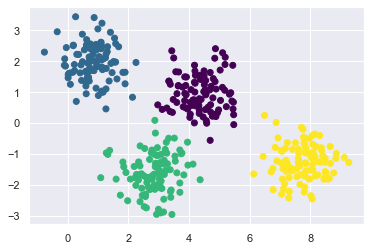

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap="viridis")

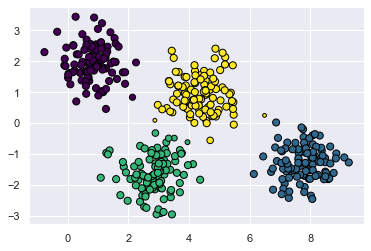

In [24]:
size = 50 * probs.max(1) ** 2 # Square emphasizes differneces
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=size, edgecolors="black")



Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

    Choose starting guesses for the location and shape

    Repeat until converged:
        E-step: for each point, find weights encoding the probability of membership in each cluster
        M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:


In [46]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angel = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis("equal")

    w_factor = .2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

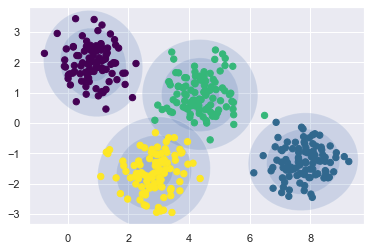

In [47]:
gmm = GMM(n_components=4, random_state=4)
plot_gmm(gmm, X)

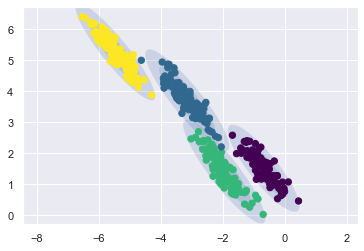

In [48]:
gmm = GMM(n_components=4, covariance_type="full", random_state=4)
plot_gmm(gmm, X_stretched)